In [1]:
import os, sys, torch, platform
print("Python:", sys.executable)
print("Torch:", torch.__version__, "| CUDA in wheel:", torch.version.cuda)
print("is_available:", torch.cuda.is_available(), "| device_count:", torch.cuda.device_count())
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
# Optional: check GPU details if visible
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
    i = torch.cuda.current_device()
    print("Using GPU index:", i, "| name:", torch.cuda.get_device_name(i))

Python: /usr/bin/python3
Torch: 2.6.0+cu124 | CUDA in wheel: 12.4
is_available: True | device_count: 1
CUDA_VISIBLE_DEVICES: None
Using GPU index: 0 | name: Tesla P100-PCIE-16GB


In [2]:
#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil


# utils / preprocessing (replaces keras.preprocessing.image)
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
# (optional) if you plan to build datasets from folders:
# from tensorflow.keras.utils import image_dataset_from_directory

# model / layers / applications
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

2025-10-01 16:05:40.902954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759334740.925581     270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759334740.932481     270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!pip install openpyxl

In [3]:
# load metadata
df_norm = pd.read_excel('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx')
df_tb = pd.read_excel('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [4]:
# Example of metadata
print('Normal metadata')
print(df_norm.head(2))
print(df_norm.shape[0])
print('_____________________________')
print('TB metadata')
print(df_tb.head(2))
print(df_tb.shape[0])

Normal metadata
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3500
_____________________________
TB metadata
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
700


In [5]:
# Join both normal and tuberculosis excels
# create Label feature ['Tuberculosis']
df_norm['Tuberculosis'] = 0.0
df_tb['Tuberculosis'] = 1.0
df_norm.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df = pd.concat([df_norm, df_tb])
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,FILE NAME,Tuberculosis
0,Normal-1084,0.0
1,Normal-1967,0.0
2,Normal-426,0.0
3,Normal-2228,0.0
4,Tuberculosis-50,1.0


In [7]:
# Rename column
df.rename(columns = {'FILE NAME':'Image'}, inplace = True)
label = ['Tuberculosis']

In [8]:
df.head()

,Image,Tuberculosis
0,Normal-1084,0.0
1,Normal-1967,0.0
2,Normal-426,0.0
3,Normal-2228,0.0
4,Tuberculosis-50,1.0


In [9]:
# create helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import plot_loss_curves, walk_through_dir, make_confusion_matrix

--2025-10-01 16:05:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-10-01 16:05:47 (72.8 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [10]:
# Walk through directory
ds = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
walk_through_dir(ds)

SOURCE_PATH_NORM = os.path.join(ds, 'Normal')
SOURCE_PATH_TB = os.path.join(ds, 'Tuberculosis')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(SOURCE_PATH_NORM))} images of Normal.")
print(f"There are {len(os.listdir(SOURCE_PATH_TB))} images of Tuberculosis.")

There are 2 directories and 3 images in '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'.
There are 0 directories and 700 images in '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis'.
There are 0 directories and 3500 images in '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'.
There are 3500 images of Normal.
There are 700 images of Tuberculosis.


In [16]:
# create whole images, train ,validation and test directories in output folder
def create_img_train_val_test_dirs(root_path):
  train_dir = os.path.join(root_path,'training')
  val_dir = os.path.join(root_path, 'validation')
  test_dir = os.path.join(root_path,'testing')
  os.makedirs(train_dir + '/Normal')
  os.makedirs(train_dir + '/Tuberculosis')
  os.makedirs(val_dir + '/Normal')
  os.makedirs(val_dir + '/Tuberculosis')
  os.makedirs(test_dir + '/Normal')
  os.makedirs(test_dir + '/Tuberculosis')
  os.makedirs(root_path + '/Images')

create_img_train_val_test_dirs('./')

In [11]:
# Map train validation test directories

IMAGE_DIR = os.path.join('/kaggle/working', 'Images')
# IMAGE_DIR = '/home/srlab/ranjbar/xai/Images'

TRAINING_DIR = "./training"
VAL_DIR = "./validation"
TESTING_DIR = "./testing"

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")

TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

**Split data for train val and test dataset**

Partition as {train : 80, Val : 10, Test : 10}

Equally split for both Normal and Tuberculosis

In [12]:
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
  for fn in zero_dir :
    print(fn,'is zero length, so ignoring.')
    
  use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)

    
split_data(SOURCE_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR,  TESTING_NORM_DIR)
split_data(SOURCE_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR,  TESTING_TB_DIR)

In [19]:
import os, sys, torch, platform
print("Python:", sys.executable)
print("Torch:", torch.__version__, "| CUDA in wheel:", torch.version.cuda)
print("is_available:", torch.cuda.is_available(), "| device_count:", torch.cuda.device_count())
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
# Optional: check GPU details if visible
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
    i = torch.cuda.current_device()
    print("Using GPU index:", i, "| name:", torch.cuda.get_device_name(i))

Python: /usr/bin/python3
Torch: 2.6.0+cu124 | CUDA in wheel: 12.4
is_available: True | device_count: 1
CUDA_VISIBLE_DEVICES: None
Using GPU index: 0 | name: Tesla P100-PCIE-16GB


In [13]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):
    
    zero_dir = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir.append([fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0])

    for fn in zero_dir :
        print(fn,'is zero length, so ignoring.')
    
    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)
    
    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR )

[] is zero length, so ignoring.


In [14]:
# create df_train, df_val, df_test
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]
    
    return df_res

In [15]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [23]:
train_df.info

<bound method DataFrame.info of                  Image  Tuberculosis
0           Normal-894           0.0
1     Tuberculosis-699           1.0
3          Normal-1478           0.0
5          Normal-2917           0.0
8          Normal-2745           0.0
...                ...           ...
4192        Normal-649           0.0
4194       Normal-1589           0.0
4195       Normal-1072           0.0
4196       Normal-2794           0.0
4199       Normal-2516           0.0

[3360 rows x 2 columns]>

In [51]:
val_df.shape

(420, 2)

In [52]:
test_df.shape

(420, 2)

In [16]:
for df in (train_df, val_df, test_df):
    df["Image"] = df["Image"].astype(str) + ".png"

In [17]:
# If we create dfs correctly, the sum of rows ahould be 4200
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4200


In [18]:
import glob
train_norm = glob.glob(TRAINING_NORM_DIR +'/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

Normal


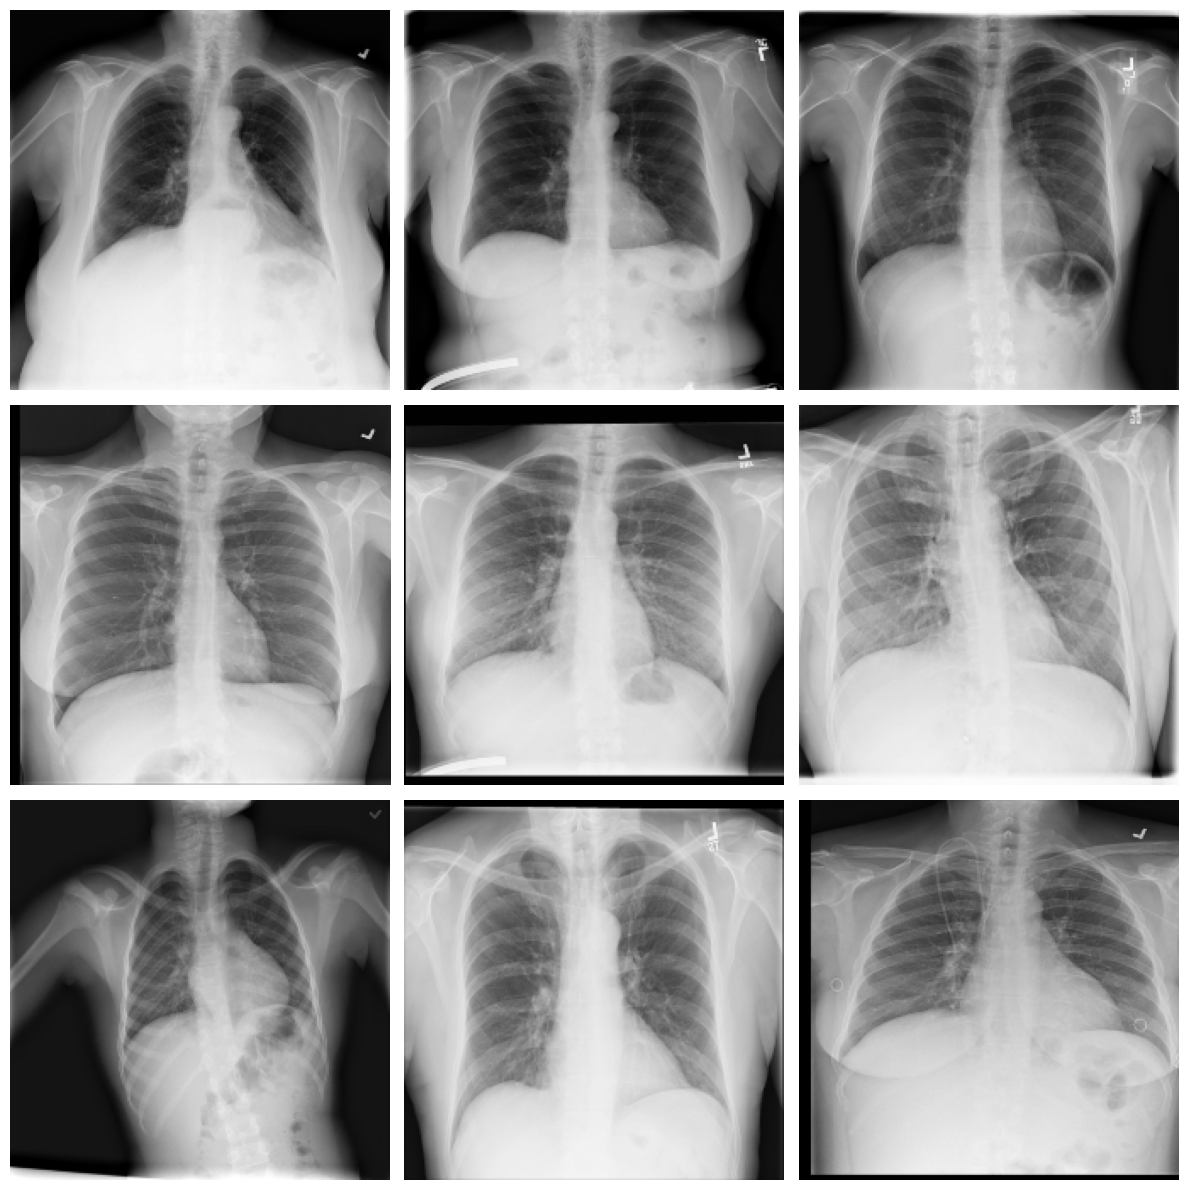

In [32]:
print('Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Tuberculosis


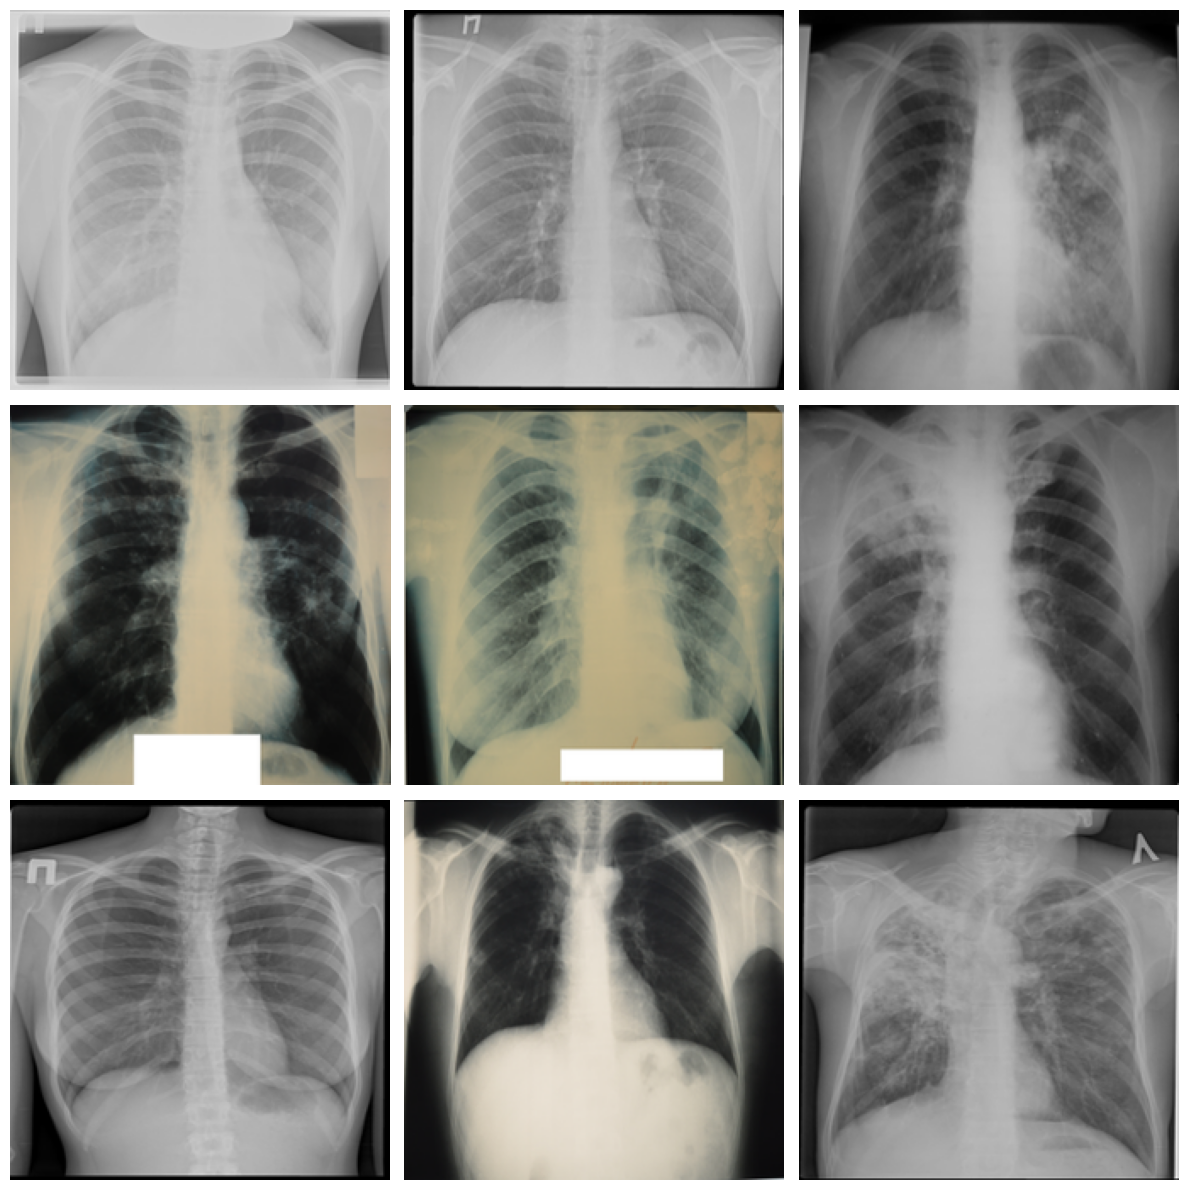

In [33]:
print('Tuberculosis')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
import os, random
from pathlib import Path
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class _PerImageStandardize(torch.nn.Module):
    """Standardize a single image tensor (C,H,W) using a single scalar mean/std over all pixels+channels."""
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x expected in [0,1] float (after ToTensor) with shape (C,H,W)
        m = x.mean()
        s = x.std().clamp_min(self.eps)
        return (x - m) / s

class _XrayTrainDataset(Dataset):
    def __init__(self, df, image_dir, x_col='Image', y_col='Tuberculosis',
                 target_w=320, target_h=320, augment=True):
        self.df = df.reset_index(drop=True)
        self.image_dir = Path(image_dir)
        self.x_col = x_col
        self.y_col = y_col
        self.size = (int(target_h), int(target_w))
        self.augment = augment
        self.std = _PerImageStandardize()

    def __len__(self):
        return len(self.df)

    def _load_image(self, path):
        # your TF pipeline decoded to 3 channels; do the same here
        img = Image.open(path).convert("RGB")
        # resize (H,W) -> PIL uses (W,H)
        img = img.resize((self.size[1], self.size[0]), Image.BILINEAR)
        # ToTensor -> float32 tensor in [0,1], shape (C,H,W)
        t = TF.to_tensor(img)
        # per-image standardization over all pixels+channels
        t = self.std(t)
        return t

    def _augment(self, x):
        # Random horizontal flip (p=0.5)
        if random.random() < 0.5:
            x = TF.hflip(x)

        # Random rotation ~±5°, translation ±10%, zoom ~±10%
        C, H, W = x.shape
        angle = random.uniform(-5.0, 5.0)
        max_dx, max_dy = 0.10 * W, 0.10 * H
        trans = (random.uniform(-max_dx, max_dx),
                 random.uniform(-max_dy, max_dy))
        scale = random.uniform(0.9, 1.1)  # zoom
        shear = 0.0

        # torchvision’s affine works on tensors (C,H,W)
        x = TF.affine(x, angle=angle, translate=(int(trans[0]), int(trans[1])),
                      scale=scale, shear=shear, interpolation=TF.InterpolationMode.BILINEAR)
        return x

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = self.image_dir / str(row[self.x_col])
        y = int(row[self.y_col])
        x = self._load_image(path)
        if self.augment:
            x = self._augment(x)
        return x, y

def get_train_loader(df, image_dir, x_col, y_col,
                     shuffle=True, batch_size=8, seed=1,
                     target_w=320, target_h=320,
                     num_workers=4, pin_memory=True):
    """
    Torch equivalent of your TF get_train_generator:
      - returns a DataLoader over an augmenting dataset
      - resize -> ToTensor -> per-image standardization -> Keras-like augs
    """
    # make worker RNG deterministic if you want reproducibility
    g = torch.Generator()
    g.manual_seed(seed)

    ds = _XrayTrainDataset(
        df=df, image_dir=image_dir, x_col=x_col, y_col=y_col,
        target_w=target_w, target_h=target_h, augment=True
    )

    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
        generator=g  # controls the initial shuffle order
    )
    return loader


In [20]:
train_loader = get_train_loader(train_df, IMAGE_DIR, 'Image', 'Tuberculosis',
                                shuffle=True, batch_size=4, seed=1,
                                target_w=320, target_h=320)

# iterate:
for images, labels in train_loader:
    images = images.cuda(non_blocking=True)  # if GPU
    labels = labels.cuda(non_blocking=True)
    # ... forward/backward

__Few things to note:__

1- We normalize validation data and incoming test data using the statistics computed from the training set

2- For reduce time consuming, we'll take a random sample of the dataset and calculate the sample mean and sample standard deviation. (Ideally, we should compute our sample mean and standard deviation using the entire training set)

In [21]:
import os, random
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# --- helper: deterministic sampler over paths ---
def _sample_paths(paths, k, seed=1):
    rng = random.Random(int(seed))
    idx = list(range(len(paths)))
    rng.shuffle(idx)
    k = min(k, len(paths))
    return [paths[i] for i in idx[:k]]

# --- compute featurewise mean/std over a sample of training images ---
@torch.no_grad()
def _compute_featurewise_stats(train_paths, img_size, sample_size=100, seed=1, device="cpu"):
    """
    Returns (mean, std) shaped (3,) computed over all pixels (H*W*k) per channel.
    Images are loaded as RGB and scaled to [0,1] via TF.to_tensor.
    """
    sample_paths = _sample_paths(train_paths, sample_size, seed=seed)
    if len(sample_paths) == 0:
        raise ValueError("Training dataframe is empty; cannot compute normalization statistics.")

    sums = torch.zeros(3, device=device)
    sqs  = torch.zeros(3, device=device)
    count = 0

    for p in sample_paths:
        img = Image.open(p).convert("RGB")
        img = img.resize((img_size[1], img_size[0]), Image.BILINEAR)  # (W,H)
        x = TF.to_tensor(img).to(device)  # (3,H,W), in [0,1]
        c, h, w = x.shape
        n = h * w
        sums += x.view(c, -1).sum(dim=1)
        sqs  += (x.view(c, -1) ** 2).sum(dim=1)
        count += n

    mean = sums / count
    var  = (sqs / count) - mean ** 2
    std  = torch.sqrt(torch.clamp(var, min=0.0)) + 1e-6
    return mean.cpu(), std.cpu()

class _XrayEvalDataset(Dataset):
    def __init__(self, df, image_dir, x_col='Image', y_col='Tuberculosis',
                 target_w=320, target_h=320, mean=None, std=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = Path(image_dir)
        self.x_col = x_col
        self.y_col = y_col
        self.size = (int(target_h), int(target_w))
        assert mean is not None and std is not None, "mean/std must be provided"
        # store as tensors for fast math
        self.mean = torch.as_tensor(mean).view(3, 1, 1)  # (3,1,1)
        self.std  = torch.as_tensor(std).view(3, 1, 1)

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = self.image_dir / str(row[self.x_col])
        y = int(row[self.y_col])

        img = Image.open(path).convert("RGB")
        img = img.resize((self.size[1], self.size[0]), Image.BILINEAR)
        x = TF.to_tensor(img)                 # (3,H,W) in [0,1]
        x = (x - self.mean) / self.std        # featurewise normalize
        return x, y

def get_test_and_valid_loader(val_df, test_df, train_df, image_dir, x_col, y_col,
                              sample_size=100, batch_size=8, seed=1,
                              target_w=320, target_h=320,
                              num_workers=4, pin_memory=True, stats_device="cpu"):
    """
    Torch equivalent of your TF get_test_and_valid_generator:
      - computes featurewise mean/std from a sample of TRAIN images resized to (H,W)
      - builds val/test datasets that use those stats (no shuffle, no aug)
      - returns DataLoaders (val_loader, test_loader)
    """
    # 1) collect absolute paths from train_df to compute stats
    train_paths = train_df[x_col].astype(str).apply(lambda p: os.path.join(str(image_dir), p)).tolist()
    mean, std = _compute_featurewise_stats(
        train_paths,
        img_size=(int(target_h), int(target_w)),
        sample_size=sample_size,
        seed=seed,
        device=stats_device
    )

    # 2) build eval datasets
    val_ds = _XrayEvalDataset(val_df, image_dir, x_col, y_col,
                              target_w=target_w, target_h=target_h,
                              mean=mean, std=std)
    test_ds = _XrayEvalDataset(test_df, image_dir, x_col, y_col,
                               target_w=target_w, target_h=target_h,
                               mean=mean, std=std)

    # 3) data loaders (no shuffle)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)
    return val_loader, test_loader, (mean, std)


In [22]:
val_loader, test_loader, (feat_mean, feat_std) = get_test_and_valid_loader(
    val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis',
    sample_size=1, batch_size=1, seed=1,
    target_w=320, target_h=320,
    num_workers=4
)

print("featurewise mean:", feat_mean.tolist())
print("featurewise std :", feat_std.tolist())


featurewise mean: [0.6874979138374329, 0.6874979138374329, 0.6874979138374329]
featurewise std : [0.22210349142551422, 0.22210349142551422, 0.22210349142551422]


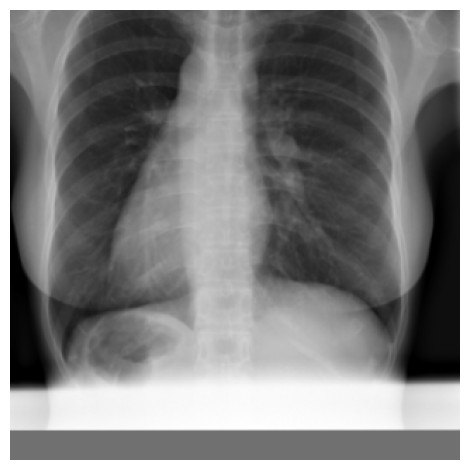

Image tensor shape (C,H,W): (3, 320, 320)
Label: 0


In [39]:
import matplotlib.pyplot as plt

# grab a batch from the train loader
x_batch, y_batch = next(iter(train_loader))  # x: [B, C, H, W], y: [B]
# pick an index (1 like your TF example), move to CPU
x0 = x_batch[1].detach().cpu()               # [C, H, W]
y0 = int(y_batch[1])

# CHW -> HWC for plotting
x0_np = x0.permute(1, 2, 0).numpy()          # [H, W, C]

# if single-channel, squeeze last dim for gray imshow
if x0_np.shape[-1] == 1:
    x0_np = x0_np[..., 0]
    cmap = 'gray'
else:
    cmap = None

# dataset images are standardized; min–max to [0,1] for display
x0_disp = (x0_np - x0_np.min()) / (x0_np.max() - x0_np.min() + 1e-6)

plt.imshow(x0_disp, cmap=cmap)
plt.axis("off")
plt.tight_layout()
plt.show()

print("Image tensor shape (C,H,W):", tuple(x0.shape))
print("Label:", y0)


***Handling class imbalance***

Fixed by Sample Weighting in Loss Function (weighting the contributions of positive and negative losses to be equal)


In [31]:
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))
print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

Percent of Tuberculosis/Normal : 20.0 %


**create positive/negative contributors**

**Final weight loss**

In [23]:
# === Fine-tuning MeanSparse on X-ray dataset (appendix cells) ===
# This block sets up the device, imports, and utility helpers.

import os, math, time, json, random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# tqdm is optional; we fallback gracefully if unavailable.
try:
    from tqdm import tqdm
    TQDM_EXISTS = True
except Exception:
    TQDM_EXISTS = False
    def tqdm(x, **kwargs):
        return x

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

# ---- REQUIRE GPU (no CPU fallback) ----
GPU_ID = int(os.environ.get("GPU_ID", "0"))  # change if you want a specific visible GPU
assert torch.cuda.is_available(), "CUDA build not available in this PyTorch or no compatible driver found."
visible_gpus = torch.cuda.device_count()
assert visible_gpus > 0, (
    "CUDA is available but no GPUs are visible. "
    "Check CUDA_VISIBLE_DEVICES, your scheduler allocation, or nvidia-smi."
)
assert 0 <= GPU_ID < visible_gpus, f"Requested GPU_ID={GPU_ID} but only {visible_gpus} visible (0..{visible_gpus-1})."

device = torch.device(f"cuda:{GPU_ID}")
torch.cuda.set_device(device)
print(f"Using device: {device}")
try:
    name = torch.cuda.get_device_name(device)
    props = torch.cuda.get_device_properties(device)
    print(f"GPU name: {name} | compute capability: {props.major}.{props.minor} | total VRAM: {props.total_memory/1e9:.1f} GB")
    try:
        free_mem, total_mem = torch.cuda.mem_get_info(device)
        print(f"VRAM free/total: {free_mem/1e9:.1f} / {total_mem/1e9:.1f} GB")
    except Exception:
        pass
except Exception as e:
    print("Could not query CUDA device details:", repr(e))

Using device: cuda:0
GPU name: Tesla P100-PCIE-16GB | compute capability: 6.0 | total VRAM: 17.1 GB
VRAM free/total: 16.8 / 17.1 GB


In [36]:
!git clone https://github.com/SPIN-UMass/MeanSparse.git

Cloning into 'MeanSparse'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 68 (delta 33), reused 42 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 45.88 KiB | 3.28 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [37]:
pip install git+https://github.com/fra31/auto-attack

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-q_gxdgqi
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-q_gxdgqi
  Resolved https://github.com/fra31/auto-attack to commit a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Preparing metadata (setup.py) ... done
  Created wheel for autoattack: filename=autoattack-0.1-py3-none-any.whl size=36228 sha256=c814e4a64db352669b8f7e8058ada4f6fbd09743d63128047b38b92fe910989e
  Stored in directory: /tmp/pip-ephem-wheel-cache-h_sdnjp1/wheels/e1/e8/28/65b2724d4c7740785979eb50bf5e1b3986ead22f6c32a87f8f
Successfully built autoattack
Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install git+https://github.com/RobustBench/robustbench.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-p0nmakgl
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-p0nmakgl
  Resolved https://github.com/RobustBench/robustbench.git to commit 78fcc9e48a07a861268f295a777b975f25155964
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-yguuvh8d/autoattack_f9fb2b02c9274d52997b7c46fe5d9bd3
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-yguuvh8d/autoattack_f9fb2b02c9274d52997b7c46fe5d9bd3
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

In [39]:
cd /kaggle/working/MeanSparse/

/kaggle/working/MeanSparse


In [40]:
mkdir models_WS

In [41]:
!pip install -U gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
robustbench 1.1 requires gdown==5.1.0, but you have gdown 5.2.0 which is incompatible.


In [42]:
import gdown

file_id = "1wHkKzSD4nk6IT0uOZa23ZFXSMBSAQ7mt"
url = f"https://drive.google.com/uc?id={file_id}"
out = "weights.bin"   # change the filename/extension if you want
gdown.download(url, out, quiet=False)
!cd /kaggle/working/MeanSparse/CIFAR10_Linfinity/WRN-94-16

Downloading...
From (original): https://drive.google.com/uc?id=1wHkKzSD4nk6IT0uOZa23ZFXSMBSAQ7mt
From (redirected): https://drive.google.com/uc?id=1wHkKzSD4nk6IT0uOZa23ZFXSMBSAQ7mt&confirm=t&uuid=f97f0ff6-b460-4ab0-8ed9-dadb855478aa
To: /kaggle/working/MeanSparse/weights.bin
100%|██████████| 1.47G/1.47G [00:09<00:00, 151MB/s] 


In [24]:
cd /kaggle/working/MeanSparse/CIFAR10_Linfinity/WRN-94-16

/kaggle/working/MeanSparse/CIFAR10_Linfinity/WRN-94-16


In [34]:
# Discover existing loaders/datasets and ensure batch_size=32. Create loaders if only datasets exist.

BATCH_SIZE = 4

def has_loader(name):
    return name in globals() and isinstance(globals()[name], DataLoader)

def has_dataset(name):
    return name in globals() and hasattr(globals()[name], "__len__") and hasattr(globals()[name], "__getitem__")

train_loader = globals().get("train_loader", None)
val_loader = globals().get("val_loader", globals().get("valid_loader", None))
test_loader = globals().get("test_loader", None)

# If only datasets are present, wrap them
if train_loader is None and has_dataset("train_dataset"):
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
if val_loader is None and has_dataset("val_dataset"):
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
if test_loader is None and has_dataset("test_dataset"):
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Sanity check / print info
def _loader_info(dl, name):
    if dl is None:
        print(f"{name}: None")
    else:
        bs = getattr(dl, 'batch_size', None)
        length = len(dl) if hasattr(dl, '__len__') else '?'
        print(f"{name}: batches={length}, batch_size={bs}")
        if bs != BATCH_SIZE:
            print(f"  NOTE: Expected batch size {BATCH_SIZE}. If you need exactly {BATCH_SIZE}, recreate the DataLoader.")

_loader_info(train_loader, "train_loader")
_loader_info(val_loader,   "val_loader")
_loader_info(test_loader,  "test_loader")

assert train_loader is not None, "train_loader not found. Please ensure your dataset is loaded as train_loader or train_dataset."
assert val_loader   is not None, "val_loader/valid_loader not found. Please ensure your dataset is loaded as val_loader or val_dataset."

train_loader: batches=840, batch_size=4
val_loader: batches=105, batch_size=4
test_loader: batches=105, batch_size=4


In [25]:
# Build MeanSparse_DMWideResNet as in AutoAttack_WRN_94_16.py, load CIFAR-10 weights, then replace classifier with 2 outputs.
# Only the new classifier is trained; all other params are frozen.

# Imports for the model (as used in your code)
from dm_wide_resnet import MeanSparse_DMWideResNet
from MeanSparse_robustarch_wide_resnet import MeanSparse
import torch.nn as nn

# Path for the pretrained CIFAR-10 weights (same naming convention as in AutoAttack_WRN_94_16.py)
name_model = "Bartoldson2024Adversarial_WRN-94-16"
directory_WS = "models_WS"

ckpt_path = '/kaggle/working/MeanSparse/weights.bin'

# Instantiate model with CIFAR-10 (10-way) head so weights load cleanly
model = MeanSparse_DMWideResNet(
    num_classes=10,
    depth=94,
    width=16,
    activation_fn=nn.SiLU,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2471, 0.2435, 0.2616),
)

# Load CIFAR-10 weights
assert os.path.exists(ckpt_path), f"Pretrained checkpoint not found at {ckpt_path}"
state = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state, strict=True)

# Utility: find & replace the *last* nn.Linear layer with a 2-way classifier
def replace_last_linear_with_2way(m: nn.Module) -> nn.Module:
    last_name, last_module = None, None
    for n, mod in m.named_modules():
        if isinstance(mod, nn.Linear):
            last_name, last_module = n, mod
    assert last_module is not None, "No nn.Linear layer found to replace"

    in_features = last_module.in_features
    new_head = nn.Linear(in_features, 2)

    # Freeze everything by default
    for p in m.parameters():
        p.requires_grad = False

    # Replace the last linear in-place via attribute path set
    parent = m
    if "." in last_name:
        parts = last_name.split(".")
        for p_name in parts[:-1]:
            parent = getattr(parent, p_name)
        setattr(parent, parts[-1], new_head)
    else:
        setattr(parent, last_name, new_head)

    # Unfreeze the new classifier only
    for p in new_head.parameters():
        p.requires_grad = True

    print(f"Replaced classifier '{last_name}' -> 2 outputs. All other params frozen.")
    return m

model = replace_last_linear_with_2way(model)
model = model.to(device)

# Optional: ensure any MeanSparse thresholds remain as in the checkpoint or set a specific value
# for name, module in model.named_modules():
#     if isinstance(module, MeanSparse):
#         module.threshold.data.fill_(0.15)

Replaced classifier 'logits' -> 2 outputs. All other params frozen.


In [26]:
# Train only the classifier for 30 epochs with Adam (lr=1e-3) and CrossEntropyLoss.

EPOCHS = 30
LR = 1e-3

# Collect only trainable parameters (the new classifier)
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(f"Trainable parameter tensors: {len(trainable_params)}")
assert len(trainable_params) > 0, "No trainable parameters found (expected the classifier head to be trainable)."

train_tb = len(os.listdir('/kaggle/working/training/Tuberculosis'))
train_norm = len(os.listdir('/kaggle/working/training/Normal'))
total = train_tb + train_norm

# Inverse-frequency weights (scaled so average weight ~1)
counts = torch.tensor([train_norm, train_tb], dtype=torch.float, device=device)
class_weights = (counts.sum() / (2.0 * counts)).clamp(min=1e-6)

print("Class counts [Normal, TB]:", counts.tolist())
print("Class weights (for CrossEntropyLoss) [Normal, TB]:", class_weights.tolist())


criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(trainable_params, lr=LR)

def _maybe_repeat_to_three(x, model):
    # If inputs are 1-channel but model expects 3, repeat channels
    try:
        # Find first conv's in_channels by scanning modules
        first_conv_in = None
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                first_conv_in = m.in_channels
                break
        if x.dim() == 4 and x.size(1) == 1 and first_conv_in == 3:
            x = x.repeat(1, 3, 1, 1)
    except Exception:
        pass
    return x

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in (tqdm(loader, desc="Eval", leave=False) if TQDM_EXISTS else loader):
        xb = _maybe_repeat_to_three(xb.to(device, non_blocking=True), model)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        if logits.dim() == 4:
           # [B, C, H, W] -> global average pooling -> [B, C]
           logits = logits.mean(dim=(2, 3))
        elif logits.dim() == 2 and logits.size(0) != yb.size(0):
           # handle flattened case [B * (H*W), C]
            if logits.size(0) % yb.size(0) == 0:
               n = logits.size(0) // yb.size(0)
               logits = logits.view(yb.size(0), n, logits.size(1)).mean(dim=1)
            else:
               raise ValueError(f"Unexpected logits size {tuple(logits.shape)} for target size {tuple(yb.shape)}")
        loss = criterion(logits, yb)
        loss_sum += loss.item() * yb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return loss_sum / total, correct / total

def train_one_epoch(epoch_idx):
    model.train()
    running = 0.0
    total, correct = 0, 0
    it = tqdm(train_loader, desc=f"Train {epoch_idx+1}/{EPOCHS}") if TQDM_EXISTS else train_loader
    for xb, yb in it:
        xb = _maybe_repeat_to_three(xb.to(device, non_blocking=True), model)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        if logits.dim() == 4:
           # [B, C, H, W] -> global average pooling -> [B, C]
           logits = logits.mean(dim=(2, 3))
        elif logits.dim() == 2 and logits.size(0) != yb.size(0):
           # handle flattened case [B * (H*W), C]
            if logits.size(0) % yb.size(0) == 0:
               n = logits.size(0) // yb.size(0)
               logits = logits.view(yb.size(0), n, logits.size(1)).mean(dim=1)
            else:
               raise ValueError(f"Unexpected logits size {tuple(logits.shape)} for target size {tuple(yb.shape)}")
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running += loss.item() * yb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

        if TQDM_EXISTS:
            it.set_postfix(loss=loss.item())

    train_loss = running / total
    train_acc = correct / total
    return train_loss, train_acc

Trainable parameter tensors: 2
Class counts [Normal, TB]: [2800.0, 560.0]
Class weights (for CrossEntropyLoss) [Normal, TB]: [0.6000000238418579, 3.0]


In [67]:
best_val_acc = -1.0
save_dir = Path("models_finetuned")
save_dir.mkdir(parents=True, exist_ok=True)
best_ckpt_path = save_dir / "meansparse_wrn94_16_xray_classifier.pt"

history = []
for epoch in range(EPOCHS):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(epoch)
    va_loss, va_acc = evaluate(val_loader)
    dt = time.time() - t0
    history.append({"epoch": epoch+1, "train_loss": tr_loss, "train_acc": tr_acc, "val_loss": va_loss, "val_acc": va_acc, "sec": dt})
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} | "
          f"{dt:.1f}s")

    # Save best (by val acc)
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save({
            "model_state": model.state_dict(),
            "best_val_acc": best_val_acc,
            "epoch": epoch + 1,
            "config": {"epochs": EPOCHS, "lr": LR, "batch_size": getattr(train_loader, "batch_size", None)},
            "note": "Classifier-only fine-tune from CIFAR-10 pretrained MeanSparse (WRN-94-16) to 2-way X-ray",
        }, best_ckpt_path)
        print(f"  Saved new best checkpoint to {best_ckpt_path} (val_acc={best_val_acc:.4f})")

print("Best val_acc:", best_val_acc)
print("Training history (last 5):", history[-5:])

Train 1/30: 100%|██████████| 840/840 [44:02<00:00,  3.15s/it, loss=0.596]


Epoch 01/30 | train_loss=0.6536 acc=0.7777 | val_loss=0.6706 acc=0.5952 | 2967.1s
  Saved new best checkpoint to models_finetuned/meansparse_wrn94_16_xray_classifier.pt (val_acc=0.5952)


Train 2/30: 100%|██████████| 840/840 [44:24<00:00,  3.17s/it, loss=0.392]


Epoch 02/30 | train_loss=0.5764 acc=0.8375 | val_loss=0.7006 acc=0.3190 | 2988.3s


Train 3/30: 100%|██████████| 840/840 [44:22<00:00,  3.17s/it, loss=0.365]


Epoch 03/30 | train_loss=0.5346 acc=0.8682 | val_loss=1.1337 acc=0.2357 | 2987.0s


Train 4/30: 100%|██████████| 840/840 [44:19<00:00,  3.17s/it, loss=0.222] 


Epoch 04/30 | train_loss=0.4891 acc=0.8744 | val_loss=0.6656 acc=0.4357 | 2984.7s


Train 5/30: 100%|██████████| 840/840 [44:18<00:00,  3.17s/it, loss=0.489] 


Epoch 05/30 | train_loss=0.4652 acc=0.8798 | val_loss=1.1944 acc=0.2452 | 2984.8s


Train 6/30: 100%|██████████| 840/840 [44:24<00:00,  3.17s/it, loss=0.172] 


Epoch 06/30 | train_loss=0.4508 acc=0.8824 | val_loss=0.8675 acc=0.2738 | 2989.4s


Train 7/30: 100%|██████████| 840/840 [44:20<00:00,  3.17s/it, loss=0.741] 


Epoch 07/30 | train_loss=0.4339 acc=0.8860 | val_loss=0.6742 acc=0.4286 | 2985.2s


Train 8/30: 100%|██████████| 840/840 [44:20<00:00,  3.17s/it, loss=0.0725]


Epoch 08/30 | train_loss=0.4090 acc=0.8988 | val_loss=0.5644 acc=0.8643 | 2986.4s
  Saved new best checkpoint to models_finetuned/meansparse_wrn94_16_xray_classifier.pt (val_acc=0.8643)


Train 9/30: 100%|██████████| 840/840 [44:24<00:00,  3.17s/it, loss=0.134] 


Epoch 09/30 | train_loss=0.4022 acc=0.9015 | val_loss=0.6153 acc=0.6167 | 2989.3s


Train 10/30: 100%|██████████| 840/840 [44:18<00:00,  3.17s/it, loss=0.828] 


Epoch 10/30 | train_loss=0.3867 acc=0.8920 | val_loss=0.6371 acc=0.5190 | 2983.6s


Train 11/30: 100%|██████████| 840/840 [44:19<00:00,  3.17s/it, loss=0.145] 


Epoch 11/30 | train_loss=0.3777 acc=0.8973 | val_loss=0.6869 acc=0.4381 | 2984.2s


Train 12/30: 100%|██████████| 840/840 [44:19<00:00,  3.17s/it, loss=0.127] 


Epoch 12/30 | train_loss=0.3728 acc=0.8949 | val_loss=2.1345 acc=0.2190 | 2984.4s


Train 13/30: 100%|██████████| 840/840 [44:18<00:00,  3.17s/it, loss=0.194] 


Epoch 13/30 | train_loss=0.3529 acc=0.9048 | val_loss=0.5991 acc=0.5976 | 2983.1s


Train 14/30: 100%|██████████| 840/840 [44:21<00:00,  3.17s/it, loss=0.238] 


Epoch 14/30 | train_loss=0.3414 acc=0.9176 | val_loss=0.9699 acc=0.2810 | 2986.8s


Train 15/30: 100%|██████████| 840/840 [44:19<00:00,  3.17s/it, loss=0.321] 


Epoch 15/30 | train_loss=0.3365 acc=0.9110 | val_loss=0.9100 acc=0.3143 | 2984.8s


Train 16/30: 100%|██████████| 840/840 [44:19<00:00,  3.17s/it, loss=0.783] 


Epoch 16/30 | train_loss=0.3273 acc=0.9185 | val_loss=0.5765 acc=0.6714 | 2984.5s


Train 17/30: 100%|██████████| 840/840 [44:22<00:00,  3.17s/it, loss=0.477] 


Epoch 17/30 | train_loss=0.3242 acc=0.9176 | val_loss=0.6347 acc=0.5643 | 2986.8s


Train 18/30: 100%|██████████| 840/840 [44:22<00:00,  3.17s/it, loss=0.131] 


KeyboardInterrupt: 

Loaded with:
  missing keys   : 0
  unexpected keys: 0
✅ Model ready on cuda
Accuracy: 0.8786
Precision (macro): 0.9135 | Recall (macro): 0.6414 | F1 (macro): 0.6857
Precision (weighted): 0.8876 | Recall (weighted): 0.8786 | F1 (weighted): 0.8499

Per-class report:

              precision    recall  f1-score   support

     class_0       0.87      1.00      0.93       350
     class_1       0.95      0.29      0.44        70

    accuracy                           0.88       420
   macro avg       0.91      0.64      0.69       420
weighted avg       0.89      0.88      0.85       420



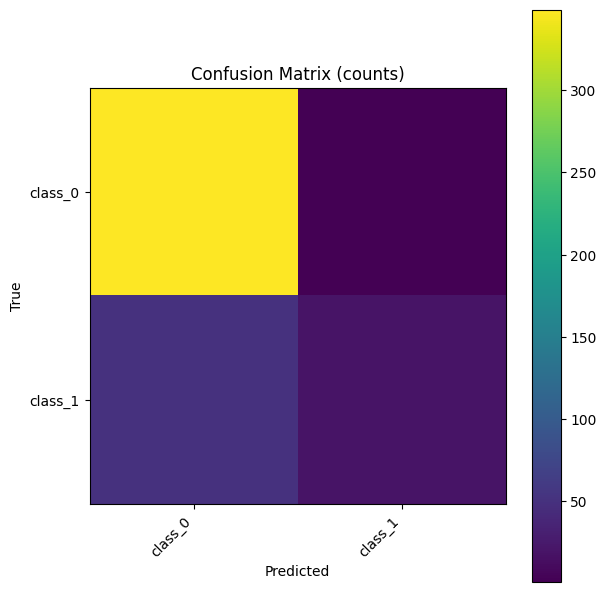

In [37]:
# Metrics + Confusion Matrix for a fine-tuned (multi-class) classifier
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import OrderedDict

# ---- EDIT if needed ----
loader = test_loader          # e.g., your DataLoader for the test split
WEIGHTS_PATH = r"/kaggle/input/meansparse_wrn94_16_xray_classifier.pt/pytorch/default/1/meansparse_wrn94_16_xray_classifier.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _strip_prefix(sd, prefixes=("module.", "model.")):
    out = OrderedDict()
    for k, v in sd.items():
        for p in prefixes:
            if k.startswith(p):
                k = k[len(p):]
        out[k] = v
    return out

# 1) load the checkpoint container (not directly into the model)
ckpt = torch.load(WEIGHTS_PATH, map_location="cpu")  # safe; we'll move to GPU after

# 2) pick the right field that actually holds the weights
if isinstance(ckpt, dict):
    if "model_state" in ckpt and isinstance(ckpt["model_state"], dict):
        state_dict = ckpt["model_state"]
    elif "state_dict" in ckpt and isinstance(ckpt["state_dict"], dict):
        state_dict = ckpt["state_dict"]
    else:
        # maybe it already IS a state_dict
        state_dict = ckpt
else:
    # very rare: a saved nn.Module object
    state_dict = ckpt.state_dict()

# 3) clean common prefixes (DataParallel: 'module.', some codebases: 'model.')
state_dict = _strip_prefix(state_dict, prefixes=("module.", "model."))

# 4) load + report mismatches (strict=False shows issues without crashing)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Loaded with:")
print("  missing keys   :", len(missing))
print("  unexpected keys:", len(unexpected))

# 5) move to your actual device and set eval
model.to(device).eval()
print("✅ Model ready on", device)

# Try to infer class names (works if you used torchvision.datasets.ImageFolder)
try:
    class_names = loader.dataset.classes
except Exception:
    # Fallback: build generic names from the model's output size
    with torch.no_grad():
        for xb, _ in loader:
            n_classes = model(xb.to(device)).shape[-1]
            break
    class_names = [f"class_{i}" for i in range(n_classes)]

y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        if logits.dim() == 4:
           # [B, C, H, W] -> global average pooling -> [B, C]
           logits = logits.mean(dim=(2, 3))
        elif logits.dim() == 2 and logits.size(0) != yb.size(0):
           # handle flattened case [B * (H*W), C]
            if logits.size(0) % yb.size(0) == 0:
               n = logits.size(0) // yb.size(0)
               logits = logits.view(yb.size(0), n, logits.size(1)).mean(dim=1)
            else:
               raise ValueError(f"Unexpected logits size {tuple(logits.shape)} for target size {tuple(yb.shape)}")
        # If you used multi-crop/TTA and flattened B*k, fold back (safe guard)
        if logits.shape[0] != yb.shape[0] and logits.shape[0] % yb.shape[0] == 0:
            k = logits.shape[0] // yb.shape[0]
            logits = logits.view(yb.shape[0], k, -1).mean(1)

        pred = logits.argmax(1).cpu().numpy()
        y_true.append(yb.numpy())
        y_pred.append(pred)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (macro): {prec_macro:.4f} | Recall (macro): {rec_macro:.4f} | F1 (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec_weighted:.4f} | Recall (weighted): {rec_weighted:.4f} | F1 (weighted): {f1_weighted:.4f}")
print("\nPer-class report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion Matrix (counts)
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

fig = plt.figure(figsize=(6 + 0.15*len(class_names), 6 + 0.15*len(class_names)))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (counts)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


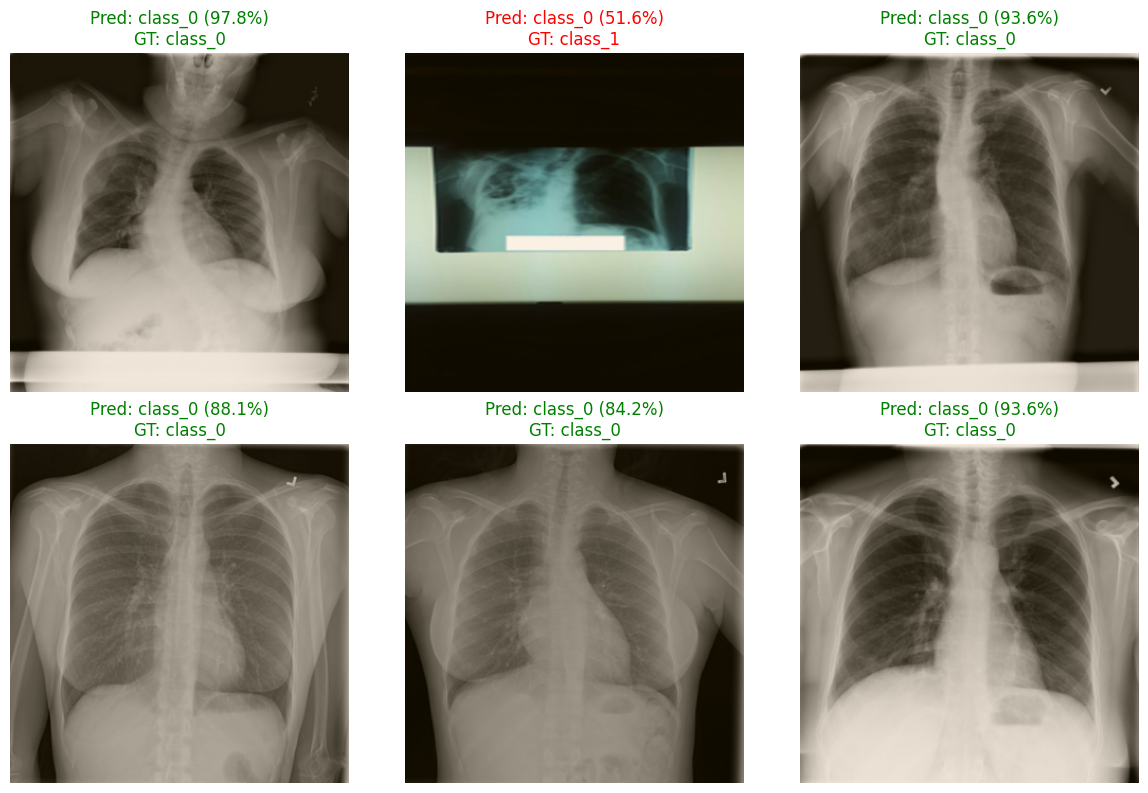

In [39]:
# ▶️ Display 6 X-ray images with prediction vs GT (and confidence)
import torch, numpy as np, matplotlib.pyplot as plt
from torch.nn.functional import softmax

model.eval()

# --- helper: handle grayscale/RGB + (optional) de-normalize for nicer display ---
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def to_display_numpy(img_tensor, mean=None, std=None):
    """
    img_tensor: (C,H,W) torch tensor, possibly normalized
    Returns: (H,W,C) float [0,1] numpy array for plt.imshow
    """
    x = img_tensor.detach().cpu().float().numpy()   # (C,H,W)
    if x.ndim == 3:
        # guess channel count
        C, H, W = x.shape
        if C == 1:
            x = x[0]  # (H,W), grayscale
            # attempt simple de-norm if given
            if mean is not None and std is not None:
                x = (x * std) + mean
            # if values look like [-1,1] or something odd, just min-max scale
            x_min, x_max = x.min(), x.max()
            if x_max - x_min > 1.5:  # likely not in [0,1]
                x = (x - x_min) / (x_max - x_min + 1e-8)
            x = np.clip(x, 0, 1)
            # convert grayscale (H,W) -> (H,W,3) for consistent imshow layout
            x = np.stack([x, x, x], axis=-1)
            return x
        else:
            # RGB
            if mean is not None and std is not None:
                x = (np.transpose(x, (1,2,0)) * std) + mean
            else:
                x = np.transpose(x, (1,2,0))
            x = np.clip(x, 0, 1)
            # If ranges look odd, min-max for safety
            if x.max() - x.min() > 1.5:
                x = (x - x.min()) / (x.max() - x.min() + 1e-8)
            return x
    else:
        # unexpected, fallback
        x = (x - x.min()) / (x.max() - x.min() + 1e-8)
        return np.stack([x, x, x], axis=-1)

def fold_logits_if_needed(logits, bsz):
    # Handles 4D logits (B,C,H,W) -> GAP and B*k flattens
    if logits.dim() == 4:
        logits = logits.mean(dim=(2,3))
    if logits.size(0) != bsz and logits.size(0) % bsz == 0:
        k = logits.size(0) // bsz
        logits = logits.view(bsz, k, -1).mean(1)
    return logits

# --- collect 6 samples from test_loader ---
imgs, gts = [], []
for xb, yb in test_loader:
    for i in range(xb.size(0)):
        imgs.append(xb[i])
        gts.append(int(yb[i]))
        if len(imgs) == 6:
            break
    if len(imgs) == 6:
        break

images = torch.stack(imgs, dim=0)   # (6,C,H,W)
labels = torch.tensor(gts)

# --- forward pass ---
with torch.no_grad():
    logits = model(images.to(device))
    logits = fold_logits_if_needed(logits, images.size(0))
    probs = softmax(logits, dim=1).cpu().numpy()
    preds = probs.argmax(axis=1)

# --- pick names ---
try:
    class_names  # from previous cell
except NameError:
    class_names = [f"class_{i}" for i in range(probs.shape[1])]

# Try to pick sensible de-norm defaults
C = images.shape[1]
if C == 1:
    dn_mean, dn_std = 0.5, 0.5  # common for grayscale pipelines
    denorm = lambda t: to_display_numpy(t, mean=dn_mean, std=dn_std)
else:
    denorm = lambda t: to_display_numpy(t, mean=IMAGENET_MEAN, std=IMAGENET_STD)

# --- plot ---
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(6):
    arr = denorm(images[i])
    gt = class_names[labels[i]]
    pd = class_names[preds[i]]
    conf = probs[i, preds[i]]
    color = "green" if pd == gt else "red"
    axes[i].imshow(arr)
    axes[i].set_title(f"Pred: {pd} ({conf*100:.1f}%)\nGT: {gt}", color=color)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [47]:
pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# === Efficient Captum PGD attack (model normalizes internally) ===
import os, gc, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from torch.utils.data import DataLoader
from collections import OrderedDict

# Paper params
EPS = 4/255.0
STEPS = 10
ALPHA = 1/255.0
RANDOM_START = True
USE_FP16 = True  # set False if your model dislikes FP16

# (helps with fragmentation; set before first CUDA alloc)
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

WEIGHTS_PATH = r"/kaggle/input/meansparse_wrn94_16_xray_classifier.pt/pytorch/default/1/meansparse_wrn94_16_xray_classifier.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = False

# --- Captum PGD ---
try:
    from captum.robust import PGD
except ImportError as e:
    raise RuntimeError("Captum is required. Install with: pip install captum") from e

def _strip_prefix(sd, prefixes=("module.", "model.")):
    out = OrderedDict()
    for k, v in sd.items():
        for p in prefixes:
            if k.startswith(p):
                k = k[len(p):]
        out[k] = v
    return out

def fold_logits_if_needed(logits, bsz, yb=None):
    if logits.dim() == 4:
        logits = logits.mean(dim=(2,3))
    if yb is not None and logits.dim() == 2 and logits.size(0) != yb.size(0):
        if logits.size(0) % yb.size(0) == 0:
            n = logits.size(0) // yb.size(0)
            logits = logits.view(yb.size(0), n, logits.size(1)).mean(dim=1)
        else:
            raise ValueError(f"Unexpected logits size {tuple(logits.shape)} for target size {tuple(yb.shape)}")
    return logits
    
# 1) load the checkpoint container (CPU)
ckpt = torch.load(WEIGHTS_PATH, map_location='cpu')

# 2) find the state_dict
if isinstance(ckpt, dict):
    if "model_state" in ckpt and isinstance(ckpt["model_state"], dict):
        state_dict = ckpt["model_state"]
    elif "state_dict" in ckpt and isinstance(ckpt["state_dict"], dict):
        state_dict = ckpt["state_dict"]
    else:
        state_dict = ckpt
else:
    state_dict = ckpt.state_dict()

# 3) clean prefixes and load
state_dict = _strip_prefix(state_dict, prefixes=("module.", "model."))
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Loaded with:")
print("  missing keys   :", len(missing))
print("  unexpected keys:", len(unexpected))

# free CPU copies + any stale CUDA cache before moving
del ckpt, state_dict, missing, unexpected
gc.collect()

# 4) move, eval, freeze
model.to(device).eval()
for p in model.parameters():
    p.requires_grad_(False)

# Optional: downcast weights for big memory win (eval-only)
if USE_FP16 and device.type == "cuda":
    model.half()
    print("⚙️  Model cast to FP16 for eval/attack.")

print("✅ Model ready & frozen on", device)


loader_eval = test_loader          # e.g., your DataLoader for the test split

def ce_folded_vec(outputs, target):
    # --- fold to [B, C] so target shape matches ---
    B = target.size(0)
    if outputs.dim() == 4:                         # [B, C, H, W] -> [B, C]
        outputs = outputs.mean(dim=(2, 3))
    if outputs.dim() == 2 and outputs.size(0) != B:
        if outputs.size(0) % B == 0:               # e.g., multi-crop [B*k, C]
            k = outputs.size(0) // B
            outputs = outputs.view(B, k, outputs.size(1)).mean(dim=1)
        else:
            raise ValueError(f"Unexpected logits shape {tuple(outputs.shape)} for target batch {B}")

    # --- standard CE but make it 1-D of length 1 so Captum can index it ---
    loss = F.cross_entropy(outputs, target, reduction='mean')
    return loss.unsqueeze(0)  # shape (1,), not scalar
    
pgd = PGD(
    forward_func=model,               # call model(x) directly
    loss_func= ce_folded_vec,        # mean loss inside PGD
    lower_bound=0.0,
    upper_bound=1.0,
)

# Tidy any leftover CUDA allocations before we start
if device.type == "cuda":
    torch.cuda.empty_cache()

# ---- Evaluation: CLEAN vs PGD ----
y_true_all, y_pred_clean_all, y_pred_adv_all = [], [], []

autocast_on = (device.type == "cuda" and USE_FP16)

for xb, yb in loader_eval:
    # NOTE: dataset should yield *pixel-space* tensors in [0,1].
    # If your dataset already normalizes, REMOVE that transform to avoid double-normalization,
    # because the WRN normalizes internally (as seen in your stack trace).
    xb = xb.to(device, non_blocking=True)
    yb = yb.to(device, non_blocking=True)

    if USE_FP16 and xb.dtype == torch.float32:
        xb = xb.half()
        
    # print('x shape: ', xb.shape)
    
    # CLEAN prediction (no autograd state at all)
    with torch.inference_mode(), torch.cuda.amp.autocast(enabled=autocast_on):
        logits_clean = model(xb)
        logits_clean = fold_logits_if_needed(logits_clean, xb.size(0), yb=yb)
        pred_clean = logits_clean.argmax(1)
        # print(' pred_clean: ', pred_clean)

    # PGD adversarial example (Captum will enable grad on inputs internally)
    adv = pgd.perturb(
        inputs=xb,                 # pixel space input
        radius=EPS,
        step_size=ALPHA,
        step_num=STEPS,
        target=yb,
        targeted=False,
        random_start=RANDOM_START,
        norm="Linf",
    ).detach()

    # ADV prediction
    with torch.inference_mode(), torch.cuda.amp.autocast(enabled=autocast_on):
        logits_adv = model(adv)
        logits_adv = fold_logits_if_needed(logits_adv, adv.size(0), yb=yb)
        pred_adv = logits_adv.argmax(1)

    y_true_all.append(yb.cpu().numpy())
    y_pred_clean_all.append(pred_clean.cpu().numpy())
    y_pred_adv_all.append(pred_adv.cpu().numpy())

    # cleanup per-iteration
    del xb, yb, adv, logits_clean, logits_adv, pred_clean, pred_adv
    if device.type == "cuda":
        torch.cuda.empty_cache()

y_true  = np.concatenate(y_true_all)
y_clean = np.concatenate(y_pred_clean_all)
y_adv   = np.concatenate(y_pred_adv_all)

# ---- Metrics & deltas ----
def summarize(y_true, y_pred, label):
    acc = accuracy_score(y_true, y_pred)
    pm, rm, fm, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    pw, rw, fw, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    print(f"\n=== {label} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro  P/R/F1: {pm:.4f} / {rm:.4f} / {fm:.4f}")
    print(f"Weighted P/R/F1: {pw:.4f} / {rw:.4f} / {fw:.4f}")
    return dict(acc=acc, prec_macro=pm, rec_macro=rm, f1_macro=fm,
                prec_weighted=pw, rec_weighted=rw, f1_weighted=fw)

m_clean = summarize(y_true, y_clean, "CLEAN")
m_adv   = summarize(y_true, y_adv,   f"PGD (ε={EPS:.5f}, steps={STEPS}, α={ALPHA:.5f})")

print("\n=== DELTAS (CLEAN - PGD) ===")
for k in ["acc","prec_macro","rec_macro","f1_macro","prec_weighted","rec_weighted","f1_weighted"]:
    print(f"{k}: {m_clean[k]-m_adv[k]:.4f}")

# ---- Confusion matrices + reports ----
num_classes = len(class_names)
cm_clean = confusion_matrix(y_true, y_clean, labels=range(num_classes))
cm_adv   = confusion_matrix(y_true, y_adv,   labels=range(num_classes))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, cm, title in zip(axes, [cm_clean, cm_adv], ["CLEAN", "PGD (adv)"]):
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(f"Confusion Matrix — {title}")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    tick_marks = np.arange(num_classes)
    ax.set_xticks(tick_marks); ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticks(tick_marks); ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
plt.show()

print("\nPer-class report (CLEAN):")
print(classification_report(y_true, y_clean, target_names=class_names, zero_division=0))
print("\nPer-class report (PGD):")
print(classification_report(y_true, y_adv, target_names=class_names, zero_division=0))


Loaded with:
  missing keys   : 0
  unexpected keys: 0
⚙️  Model cast to FP16 for eval/attack.
✅ Model ready & frozen on cuda
